In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
Tc1 = 30 #Temperature in Celsius
Tc2 = 60 #Temperature in Celsius

#Universal constants:
R = 8.314 # [m^3*Pa/K/mol]

def Kelvin_Celsius(t):
    """
    This function converts Temperature values from Kelvin to degrees Celsius
    """
    return t-273.15

def Celsius_Kelvin(t):
    """
    This function converts Temperature values from degrees Celsius to Kelvin
    """
    return t+273.15

T1 = Celsius_Kelvin(Tc1)
T2 = Celsius_Kelvin(Tc2)

### Process Parameters
Further parameters, including the superficial gas velocity (vcgs), the liquid volume (VL), the gas holdup fraction (ε), the pressure at the bottom of the tank (Pb), and the logarithmic mean pressure (Pm) can be defined from the basic properties of the reactor (eq. 1-5).

<p> Superficial gas velocity: </p>
<div style="text-align: center">  $ v^c_{gs} = F_av/(\pi * r^2)/3600 $ [m/s]
    <span style="float:right;">(eq. 2)</span>
</div>

<p> Liquid volume, assuming 2/3 filled: </p> 
<div style="text-align: center">  $ V_L = π * r^2 * h * 2/3 $ [$m^3$]
    <span style="float:right;">(eq. 3)</span>
</div>

<p> Gas holdup fraction: </p> 
<div style="text-align: center">  $ \varepsilon = 0.6*(v^c_{gs})^{0.7} $     
    <span style="float:right;">(eq. 4)</span>
</div>

<p> Pressure at the bottom, assuming 2/3 filled: </p> 
<div style="text-align: center">  $ P_b = P_t + h * 2/3 * 1000 * g $ [Pa]
    <span style="float:right;">(eq. 5)</span>
</div>

<p> Logarithmic mean pressure: </p> 
<div style="text-align: center">  $ P_m = (P_b-P_t)/log(P_b/P_t) $ [Pa]
    <span style="float:right;">(eq. 6)</span>
</div>


Where:
- $F_av$: Average gas flow rate ($m^{3}/h)$
- $r$: reactor radius (m)
- $P_b$: reactor bottom pressure (Pa)
- $P_t$: reactor top pressure (Pa)

In [3]:
h_r = 30 # height of the reactor [m]
ar = 5 # aspect ratio: height to diameter
v_gas = 0.5 # [m/s]

r = h_r/(ar * 2)
h = 2/3 * h_r # initial height of broth  assuming it is 2/3 filled [m]
A = math.pi * r**2 #reactor cross-sectional area [m^2]
V_L = A * h #reactor volume [m^3]

p_t = 101325 # pressure at the top of the reactor [Pa]
p_b = p_t + h * 1000 * 9.81 # pressure at the bottom of the reactor [Pa]
p_m = (p_b-p_t)/math.log(p_b/p_t) # logarithmic mean pressure [Pa]

h,r,A,V_L

(20.0, 3.0, 28.274333882308138, 565.4866776461628)

# Express transfer rates

<p> Transfer rate: </p>
<div style="text-align: center">  $ R_{i} = k_La_{i,T}*(c^* -c_l) $ [$mol/m^3/s$]
</div>

<p> Volumetric mass transfer coefficient as identified for $O_2$ in a BRC: </p>
<div style="text-align: center">  $ k_La_{O_2,20} = 0.32 * (v^c_{gs})^{0.7} $ [$1/s$]
</div>

<p> Temperature corrected volumetric mass transfer coefficient: </p>
<div style="text-align: center">  $ k_La_{T} = k_La_{T_R} * \theta ^{T-T_R} $ [$1/s$]
</div>

<p> Temperature corrected volumetric mass transfer coefficient of compound i: </p>
<div style="text-align: center">  $ k_La_{i,20} = k_La_{O_2,20} * (D_i/D_{O_2})^{0.5} * \theta ^{T-293.15} $ [$1/s$]
</div>

<p> Saturation concentration: </p>
<div style="text-align: center">  $ c^* = H_T*y*P $ [$mol/m^3$]
</div>

<p> Temperature-corrected Henry’s law constant: </p>
<div style="text-align: center">  $ H_T = H_0*e^{[k_H*((1/T)-(1/298.15))]} $ [$mol/m^3*Pa$]
</div>

<!--<p> Combined: </p>
<div style="text-align: center">  $ k_La_T = 0.32 * (D_i/D_{O_2})^{0.5} * (v^c_{gs})^{0.7} * \theta ^{T-293.15} $ </div>
<div style="text-align: center">  $ c^* = H_0*e^{[k_H*((1/T)-(1/298.15))]}*10^3*y*P $ </div>-->

where:
- $k_La_T$: Volumetric mass transfer coefficient at temperature T (1/s)
- $c^*$: Saturation concentration ($mol/m^{3}$)
- $c_l$: Concentration of gas in the liquid ($mol/m^{3}$)
- $k_La_{20}$: Volumetric mass transfer coefficient at 20 C (1/s)
- $D_i$: Diffusion coefficient ($m^{2}/s$)
- $D_{O_2}$: Diffusion coefficient of oxygen ($m^{2}/s$)
- $v^c_{gs}$: Superficial gas velocity (m/s)
- $T$: Temperature (K)
- $\theta$: temperature correction factor
- $H_T$: Temperature corrected Henry's law constant ($mol/(m^{3}·Pa)$)
- $y$: Mol fraction (mol/mol)
- $P$: Pressure (Pa)
- $H_0$: Temperature corrected Henry's law constant at 0K ($mol/(m^{3}·Pa)$)
- $k_H$: Henry's law temperature correction factor (K)

In [4]:
# Kla constant:
def KLa(C,T):
    return 0.32 * (DR[C]/DR["O2"])**0.5 * v_gas**0.7 * theta**(T-293.15)#[1/s]

# Saturation concentration
def Csat(C, T, c_G):
    return HR[C] * math.e**(kh[C]*(1/T-1/298.15)) * 10**(-5) * c_G * R * T

# Combine as transfer rate:
def RT(C,T,c_L,c_G):
    return KLa(C,T) * (Csat(C,T,c_G) - c_L)

# Include growth rate and NGAM through a Pirt Model

<p>According to Pirt kinetics, the specific consumption and production rates can be modelled as following: </p>
<br>
<div style="text-align: center">  $ q_i = \displaystyle \frac{µ}{Y_{Xi}} + m_{NGAM,i} $ [$h^{-1}$]
</div>
<br>
<p>With:</p>
<div style="text-align: center">  $ m_{NGAM,i} = 
\displaystyle \frac{m_{NGAM}}{-\Delta _r G^T}*S_{i,cata}$ [$h^{-1}$]
</div>

<p>Catabolic reaction stoichiometries:</p>

<p>$ 2 CO_2 + 4 H_2 <=> CH_3COOH + 2 H_2O $ </p>

Where:
- $Y_{IJ}$: Yield of compound I on J
- $µ$: growth rate (/h)
- $m_{NGAM}(T)$: temperature-dependent non-growth-associated maintenance energy requirement ($kJ/h/Cmol_{biomass}$)
- $S_i$: Stoichiometric factor of compound i
- $\Delta _r G^T$: temperature-dependent Gibbs free energy of reaction per mol product ($kJ/mol$)

subscripts:
 - S: of substrate, electron donor CO or H2
 - X: of biomass 
 - P: of product, acetate
 - ana: in anabolic reaction
 - cata: in catabolic reaction

# Calculate reaction thermodynamics

<p>Gibbs free energy of reaction: </p>
<div style="text-align: center">  $ \Delta _r G^0 = \sum_i v_i * \Delta _fG_i^0$ [$kJ/mol$]
    <span style="float:right;">(eq. 23)</span>
</div>

<p>Reaction enthalpy: </p>
<div style="text-align: center">  $ \Delta _r H^0 = \sum_i v_i * \Delta _fH_i^0$ [$kJ/mol$]
    <span style="float:right;">(eq. 24)</span>
</div>

<p>Gibbs-Helmoltz equation: </p>
<div style="text-align: center">  $ \Delta _r G^T = \Delta _r G^0*(T/298.15) +\Delta _r H^0 * (1-T/298.15) $ [$kJ/mol$]
    <span style="float:right;">(eq. 25)</span>
</div>

In [5]:
# Load Henry's Law Constants:
DR = pd.read_csv("../Data/HenrysLawData.csv", index_col = "Compound")["DR"]
HR = pd.read_csv("../Data/HenrysLawData.csv", index_col = "Compound")["HR"]
kh = pd.read_csv("../Data/HenrysLawData.csv", index_col = "Compound")["k"]
theta = 1.022 # temperature correction factor

# Load the thermodynamic data of the compounds
dfGR = pd.read_csv("../Data/EnthalpyGibbs.csv", index_col="Compound")["dfGR"]
dfHR = pd.read_csv("../Data/EnthalpyGibbs.csv", index_col="Compound")["dfHR"]

In [6]:
S = pd.DataFrame({
    'Cata':  [-4,  0,    -2,  2,    0,1],
    'Ana':   [-2.1, -0.2, -1,  1.5,  1,0]},
    index=pd.Index(["H2","NH3","CO2","Water","X","Acetate"]))

#Hess's law, as vector multiplication:
DrGR = np.nansum(S.Cata * dfGR)
DrHR = np.nansum(S.Cata * dfHR)

#Gibbs–Helmholtz equation for temperature correction (eq.26)
def DrGT(T):
    return DrGR * (T/298.15) + DrHR * (1-T/298.15)

## Non-Growth-Associated Maintenance

For GAM a temperature correlation has been found. Based on a wide range of studied anaerobic organisms, NGAM can be estimated through the temperature-dependent expression based on the Arrhenius expression, as proposed by Tijhuis et al. (eq. 23), an approximation for ($m_{g}$) also used by Redl et al., 2017..

<p> NGAM: </p>
<div style="text-align: center">  $ m_{NGAM} = 3.3^{69000/R*(1/298-1/T)} $ [$kJ/h/Cmol_{biomass}$]
</div>

\[REF]: L. Tijhuis, M.C. M. van Loosdrecht, and J. J. Heijnen, A Thermodynamically Based Correlation for Maintenance Gibbs Energy Requirements in Aerobic and Anaerobic Chemotrophic Growth 

In [7]:
def m_NGAM(T):
    """
    This function is the Arrhenius equation, as fit by Tijsen et al.
    """
    return 3.3**(69000/R*(1/298-1/T))/3600 #[kJ/s/CmolX]

print("m_NGAM(300) =", round(m_NGAM(300),2), "[kJ/s/CmolX]")

m_NGAM(300) = 0.0 [kJ/s/CmolX]


## Define mass balances

<br>
<div> In an ideally mixed bubbel column reactor, mass balances can be defined for each compound over the gas phase and liquid phase as:<br>
    Accumulation = In - Out + Production - Consumption</div>
<br>
Compound i in the liquid: $ \frac{dc_{i}}{dt} = q_{i} * c_X + R_{i} $

Compound i in the gas: $ \frac{dc_{G,i}}{dt}=\frac{F_G}{V_G}*(c_{G,i,in}-c_{G,i})-R_{i}*\frac{V_L}{V_G}$
    
    
an equation for $c_{G,i}$ at steady state can be deduced starting with the gas phase mass balance.
    
$ \frac{F_G}{V_G}*(c_{G,i,in}-c_{G,i})=R_{i}*\frac{V_L}{V_G}$
    
$ c_{G,i}=c_{G,i,in}-R_{i}*\frac{V_L}{F_G}$
    
$ c_{G,i}=c_{G,i,in}-R_{i}*\frac{h}{v_{gas}}$
    
$ c_{G,i}=c_{G,i,in}-k_La_{i,T}*(c^*_{i,L,T}-c_{i,L})*\frac{h}{v_{gas}}$
    
for $H_2$ at steady state where all of it is consumed in the liquid (i.e.  $c_{i,H_2} = 0$), we have:
    
$ c_{G,H_2}=c_{G,H_2,in}-k_La_{H_2,T}*c^*_{H_2,L,T}*\frac{h}{v_{gas}}$
    
$ c_{G,H_2}=c_{G,H_2,in}-k_La_{H_2,T}*H_{T,H_2}*y_{H_2}*P*\frac{h}{v_{gas}}$

Using the ideal gas law: $P*V = n*R*T <=> P = c_G*R*T$, <br> inlcuding Raoult's law $ P_i = P * y_i $ <br> Yields: $y_{H_2}*P = c_{G,i}*R*T$

$ c_{G,H_2}=c_{G,H_2,in}-k_La_{H_2,T}*H_{T,H_2}*c_{G,H_2}*R*T*\frac{h}{v_{gas}}$

$ c_{G,H_2} + k_La_{H_2,T}*H_{T,H_2}*c_{G,H_2}*R*T*\frac{h}{v_{gas}} =c_{G,H_2,in}$
 
$ c_{G,H_2} *(1 + k_La_{H_2,T}*H_{T,H_2}*R*T*\frac{h}{v_{gas}})=c_{G,H_2,in}$

$ c_{G,H_2} = \frac {c_{G,H_2,in}}{1 + k_La_{H_2,T}*H_{T,H_2}*R*T*\frac{h}{v_{gas}}}$

The same can be done for CO2 when that becomes limiting:

$ c_{G,CO_2} = \frac {c_{G,CO_2,in}}{1 + k_La_{CO_2,T}*H_{T,CO_2}*R*T*\frac{h}{v_{gas}}}$

These will be defined as a function here below:

In [8]:
def c_G(C,T,y):
    c_Gin = y*p_m/(R*T)
    return c_Gin/(KLa(C,T)*HR[C]*math.e**(kh[C]*(1/T-1/298.15))*10**(-5)*R*T*h/v_gas+1)


Now using the liquid phas mass balance, we can predict the maximum achievable biomass concentration, where all available substrate is required to satisfy manintenance requirements.

Mass balance of compound i in the liquid: $ \frac{dc_{i}}{dt} = q_{i} * c_X + R_{i} $

with: $ q_i = \frac{µ}{Y_{Xi}} + m_{NGAM,i} $
Given our assumption that all substrate is needed for maintenance, we can state that µ = 0. Looking at the steady state, we have:

$ m_{NGAM,i} * c_{x,max} + R_{i} = 0 <=> c_{x,max} = \frac{-R_{i}}{m_{NGAM,i}}$

with: $ m_{NGAM,i} = \frac{m_{NGAM}}{-\Delta _r G^T}*S_{i,cata}$

gives: $c_{x,max} = \frac{R_{i}*\Delta _r G^T}{m_{NGAM}*S_{i,cata}}$

In [9]:
def c_xmax(C,T,c_G):
    return RT(C,T,0,c_G)*DrGT(T)/S.Cata[C]/m_NGAM(T)

c_xmax("H2",T1,c_G("H2",T1,0.66)),c_xmax("H2",T2,c_G("H2",T2,0.66))

(19797.485597729225, 1369.233641554368)

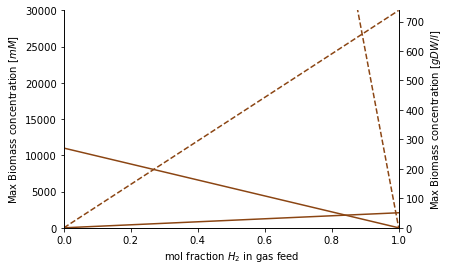

In [10]:
plt.rcParams['axes.spines.top'] = False

y = np.arange(0,1,0.0001)

plt.plot(y,c_xmax("H2",T1,c_G("H2",T1,y)), color='saddlebrown', linestyle ="--")
plt.plot(y,c_xmax("H2",T2,c_G("H2",T2,y)), color='saddlebrown', linestyle ="-")
plt.plot(y,c_xmax("CO2",T1,c_G("CO2",T1,1-y)), color='saddlebrown', linestyle ="--")
plt.plot(y,c_xmax("CO2",T2,c_G("CO2",T2,1-y)), color='saddlebrown', linestyle ="-")

plt.xlabel(r'mol fraction $H_2$ in gas feed')
plt.ylabel(r'Max Biomass concentration [$mM$]')
plt.axis([0, 1, 0, 30000])

ax2 = plt.twinx()
ax2.set_ylabel(r'Max Biomass concentration [$gDW/l$]')
plt.axis([0, 1, 0, 30000*24.6/1000])

plt.show()

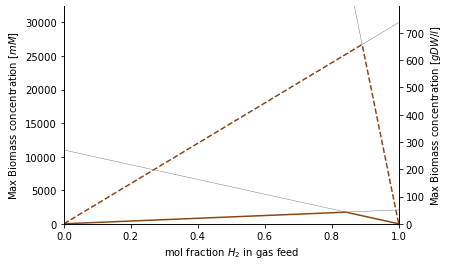

In [11]:
def c_xmax_AND(T,y):
    return np.minimum(c_xmax("H2",T,c_G("H2",T,y)),c_xmax("CO2",T,c_G("CO2",T,1-y)))
def c_xmax_OR(T,y):
    return np.maximum(c_xmax("H2",T,c_G("H2",T,y)),c_xmax("CO2",T,c_G("CO2",T,1-y)))

plt.plot(y,c_xmax_AND(T1,y), color='saddlebrown', linestyle ="--")
plt.plot(y,c_xmax_AND(T2,y), color='saddlebrown', linestyle ="-")
plt.plot(y,c_xmax_OR(T1,y), color="grey", linewidth = 0.5)
plt.plot(y,c_xmax_OR(T2,y), color="grey", linewidth = 0.5)
plt.xlabel(r'mol fraction $H_2$ in gas feed')
plt.ylabel(r'Max Biomass concentration [$mM$]')
plt.axis([0, 1, 0, 9*3600])

ax2 = plt.twinx()
ax2.set_ylabel(r'Max Biomass concentration [$gDW/l$]')
plt.axis([0, 1, 0, 9*3600*24.6/1000])
plt.show()

In [12]:
opt_30 = 0.89
opt_60 = 0.84

print(f"From the plot: the maximum achievable biomass concentration where both gasses are fully depleted in the liquid are:")

print(f"at 30°C: {round(c_xmax('H2',T1,c_G('H2',T1,opt_30)),2)}mM or {round(c_xmax('H2',T1,c_G('H2',T1,opt_30))*24.6/1000,2)}gDW/l at a H2 molar ratio of {opt_30}")
print(f"at 60°C: {round(c_xmax('H2',T2,c_G('H2',T2,opt_60)),2)}mM or {round(c_xmax('H2',T2,c_G('H2',T2,opt_60))*24.6/1000,2)}gDW/l at a H2 molar ratio of {opt_60}")

From the plot: the maximum achievable biomass concentration where both gasses are fully depleted in the liquid are:
at 30°C: 26696.61mM or 656.74gDW/l at a H2 molar ratio of 0.89
at 60°C: 1742.66mM or 42.87gDW/l at a H2 molar ratio of 0.84


### Gasseous substrates in off gas

Now calclulate for each CO2:H2 feed ratio how much of the gasses are left in the off gas, i.e. are not consumed in fermentation.

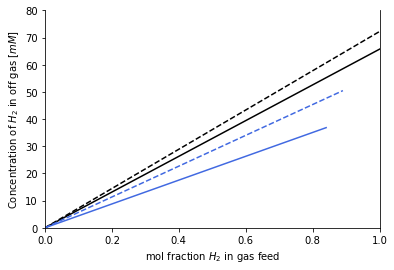

In [13]:
# plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

y_30 = np.arange(0,opt_30,0.0001)
y_60 = np.arange(0,opt_60,0.0001)


#plt.plot(y,(1-y)*p_m/(R*T1), color='black', linestyle ="--")
#plt.plot(y,(1-y)*p_m/(R*T2), color='black', linestyle ="-")
plt.plot(y,y*p_m/(R*T1), color='black', linestyle ="--") # assuming that the feed gas is not heated
plt.plot(y,y*p_m/(R*T2), color='black', linestyle ="-")
#plt.plot(y_30,c_G("CO2",T1,y_30), color='dimgray', linestyle ="--")
#plt.plot(y_60,c_G("CO2",T2,y_60), color='dimgray', linestyle ="-")
plt.plot(y_30,c_G("H2",T1,y_30), color='royalblue', linestyle ="--")
plt.plot(y_60,c_G("H2",T2,y_60), color='royalblue', linestyle ="-")
plt.xlabel(r'mol fraction $H_2$ in gas feed')
plt.ylabel(r'Concentration of $H_2$ in off gas [$mM$]')
plt.axis([0, 1, 0, 80])

plt.show()

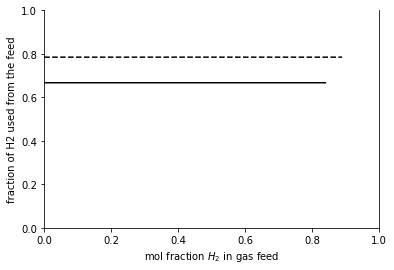

At a given temperature, the conversion yield of H2 stays constant over the range of H2 mol fractions in the gas feed, as long as H2 remains the limiting substrate.


In [14]:
# plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

y_30 = np.arange(0.0001,opt_30,0.0001)
y_60 = np.arange(0.0001,opt_60,0.0001)

plt.plot(y_30,c_G("H2",T1,y_30)/(y_30*p_m/(R*T1)), color='black', linestyle ="--")
plt.plot(y_60,c_G("H2",T2,y_60)/(y_60*p_m/(R*T2)), color='black', linestyle ="-")

plt.xlabel(r'mol fraction $H_2$ in gas feed')
plt.ylabel(r'fraction of H2 used from the feed')
plt.axis([0, 1, 0, 1])

plt.show()

print("At a given temperature, the conversion yield of H2 stays constant over the range of H2 mol fractions in the gas feed, as long as H2 remains the limiting substrate.")


# Cell Concentration, viscocity and kLa

compare Heijnen kLa estimate to one that accounts for viscosity: GAS/LIQUID MASS TRANSFER IN A SLURRY BUBBLE
COLUMN; SCHUMPE et al.

with µ_eff from: Investigating and modelling the effects of cell lysis on the rheological
properties of fermentation broths; Joseph M. Newton, Joanna Vlahopoulou, Yuhong Zhou

In [15]:
v_gas = np.arange(0, 0.3, 0.001)

def KLa(C,T,v_gas):
    return 0.32 * (DR[C]/DR["O2"])**0.5 * v_gas**0.7 * theta**(T-293.15)# * 3600 #[1/s]

def µ_eff(c_x): #(g.DCW/L)
    return 5.38 * 10**(-5) * c_x*24.6/1000 + 0.00062

def KLa_Schumpeetal(C,T,v_gas,µ_eff):
    return 0.042 * v_gas**0.82 * µ_eff**(-0.39)

### Viscocity as a function of bacterial cell concentration

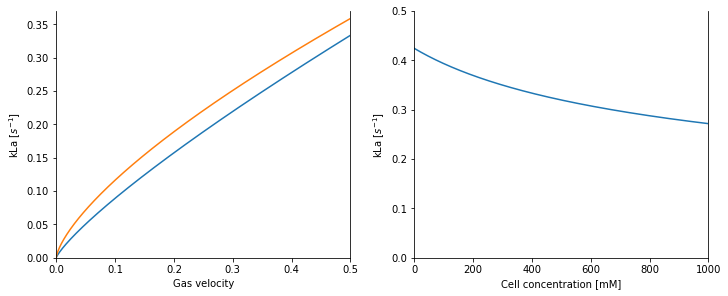

In [16]:
v_gas_R = 0.5
v_gas = np.arange(0, 0.5, 0.001)
c_xR = 400
c_x = np.arange(0.0, 1000, 0.1)

fig, axs = plt.subplots(nrows = 1, ncols = 2, constrained_layout=True, figsize=(10,4))

axs[0].plot(v_gas, KLa_Schumpeetal("H2",T1,v_gas,µ_eff(c_xR)))
axs[0].plot(v_gas, KLa("H2",T1,v_gas))
axs[1].plot(c_x, KLa_Schumpeetal("H2",T1,v_gas_R,µ_eff(c_x)))

axs[0].set_ylabel(r'kLa [$s^{-1}$]')
axs[0].set_xlabel('Gas velocity')
axs[0].set_ylim(0, 0.37)
axs[0].set_xlim(0, 0.5)
axs[1].set_ylabel(r'kLa [$s^{-1}$]')
axs[1].set_xlabel(r'Cell concentration [mM]')
axs[1].set_ylim(0, 0.5)
axs[1].set_xlim(0, 1000)

plt.show()

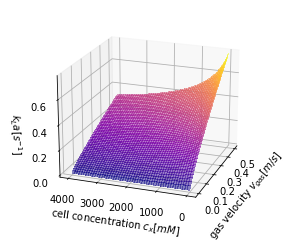

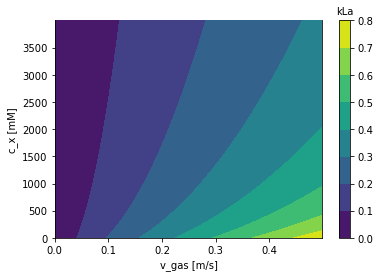

In [17]:
x = np.arange(0, 0.5, 0.001)
y = np.arange(0, 4000, 0.1)

X, Y = np.meshgrid(x, y)
Z = (DR["H2"]/DR["O2"])**0.5 * 0.042 * X**0.82*(5.38*10**(-5)*Y*24.6/1000+0.00062)**(-0.39)*theta**(T1-293.15)


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,Z, cmap='plasma', linewidth=0,antialiased=False,alpha=0.5)

ax.set_xlabel('gas velocity $v_{gas} [m/s]$')
ax.set_ylabel('cell concentration $c_x [mM]$')
ax.set_zlabel('$k_La [s^{-1}]$')

ax.view_init(20, 200)
plt.show()

plt.contourf(X, Y, Z)
plt.xlabel('v_gas [m/s]')
plt.ylabel('c_x [mM]')
clb=plt.colorbar()
clb.ax.tick_params(labelsize=10) 
clb.ax.set_title('kLa',fontsize=10)
plt.show()

# Conclusion:

The increasing cell density, especially at the high predicted concentrations seen at 30°C, will increase the broth viscocity and reduce the kLa of both gaseous substrates.

The kLa should however scale down proportionally for both gasses, according to the equation proposed by Schumpe et al., so the optimal gas composition is not expected to be affected. The maximum achievable cell concentration is decreased and the reduced kLa will decrease the overall transfer rate meaning that more substrate will leave the reactor off-gas unused. This effect is expected to be less prononounce at 60°C because the maximum cell concentrations are kept lower due to higher maintenance energy requirements.

## Try and find the max cell concentration accounting for cell density

<p> Maximum biomass concentration: </p>
$c_{x,max} = \frac{k_La_{i,T}*(c^* -c_l)*\Delta _r G^T}{m_{NGAM}*S_{i,cata}}$
</div>


<p> k_La by Schumpeetal of oxygen:
$ k_La_{O2} = 0.042 * v_{gas}^{0.82} * µ_{eff}^{0.39}$
    
with:
$µ_{eff} = 5.38 * 10^{-5} * c_x * \frac{24.6}{1000} + 0.00062$

<p> Temperature corrected volumetric mass transfer coefficient of compound i: </p>
<div style="text-align: center">  $ k_La_{i,T} = 0.042 * v_{gas}^{0.82} * (5.38 * 10^{-5} * c_x * \frac{24.6}{1000} + 0.00062)^{0.39} * (D_i/D_{O_2})^{0.5} * \theta ^{T-293.15} $ [$1/s$]
</div>

<p> Saturation concentration: </p>
<div style="text-align: center">  $ c^* = H_T*y*P $ [$mol/m^3$]
</div>

<p> Temperature-corrected Henry’s law constant: </p>
<div style="text-align: center">  $ H_T = H_0*e^{[k_H*((1/T)-(1/298.15))]} $ [$mol/m^3*Pa$]
</div>

All together:
$\frac{c_{x,max}}{(5.38 * 10^{-5} * c_{x,max} *\frac{24.6}{1000} + 0.00062)^{0.39}} = \frac{0.042 * v_{gas}^{0.82} * (D_{H_2}/D_{O_2})^{0.5} * \theta ^{T-293.15}* H_{H_2}*e^{[k_H*((1/T)-(1/298.15))]}*y_{H_2}* P *\Delta _r G^T}{m_{NGAM}*S_{H_2,cata}}$


$c_{x,max}^{1/0.39-1} = ((\frac{0.042 * v_{gas}^{0.82} * (D_{H_2}/D_{O_2})^{0.5} * \theta ^{T-293.15}* H_{H_2}*e^{[k_H*((1/T)-(1/298.15))]}*y_{H_2}* P *\Delta _r G^T}{m_{NGAM}*S_{H_2,cata}})^{0.39} - 0.00062)*5.38 * 10^{-5}* \frac{24.6}{1000}$


$c_{x,max} = (((\frac{0.042 * v_{gas}^{0.82} * (D_{H_2}/D_{O_2})^{0.5} * \theta ^{T-293.15}* H_{H_2}*e^{[k_H*((1/T)-(1/298.15))]}*y_{H_2}* P *\Delta _r G^T}{m_{NGAM}*S_{H_2,cata}})^{0.39} - 0.00062)*5.38 * 10^{-5}* \frac{24.6}{1000})^{1/(1/0.39-1)}$

In [18]:
v_gas = 0.5
def c_xmax_visc(C,T,y):
    return (((0.042*v_gas**0.82*(DR[C]/DR.O2)**0.5*theta**(T-293.15)* HR[C]*math.e**(kh[C]*(1/T)-(1/298.15))*y*p_m*DrGT(T)/(m_NGAM(T)*S.Cata[C]))**0.39-0.00062)*5.38*10**(-5)*24.6/1000)**(1/(1/0.39-1))

def KLa(C,T):
    return 0.32 * (DR[C]/DR["O2"])**0.5 * v_gas**0.7 * theta**(T-293.15)# * 3600 #[1/s]

(0.0, 1.0, 0.001, 100000.0)

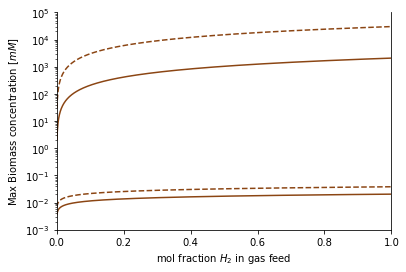

In [19]:
y = np.arange(0.001,1, 0.001)
plt.plot(y,c_xmax("H2",T1,c_G("H2",T1,y)), color='saddlebrown', linestyle ="--")
plt.plot(y,c_xmax("H2",T2,c_G("H2",T2,y)), color='saddlebrown', linestyle ="-")
plt.plot(y,c_xmax_visc("H2",T1,y), color='saddlebrown', linestyle ="--")
plt.plot(y,c_xmax_visc("H2",T2,y), color='saddlebrown', linestyle ="-")
plt.xlabel(r'mol fraction $H_2$ in gas feed')
plt.ylabel(r'Max Biomass concentration [$mM$]')
plt.yscale("log")
plt.axis([0, 1, 0.001, 100000])

This is much too low, there must be an error somewhere.